(2479, 988)
(2479, 988)
Fitting estimator with 988 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 958 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 928 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 898 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Fitting estimator with 868 features.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


850 selected features
200 selected features
199 selected features
--------------------------------------- Pearson Correlation ------------------------------
(2479, 850)
2479
Training Accuracy: 100.0 %
Test Accuracy: 89.61600865332612 %


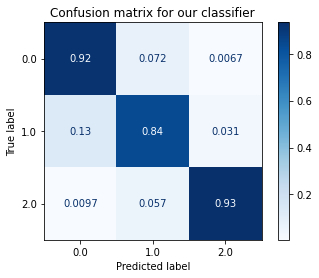

--------------------------------------- Chi-Squared ------------------------------
(2479, 850)
2479
Training Accuracy: 100.0 %
Test Accuracy: 88.967009194159 %


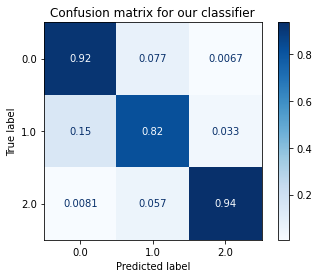

--------------------------------------- Recursive Feature Elimination ------------------------------
(2479, 850)
2479
Training Accuracy: 100.0 %
Test Accuracy: 89.45375878853434 %


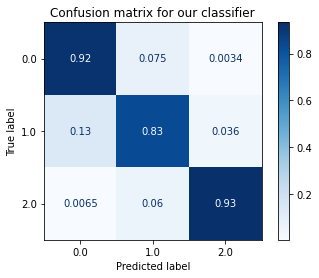

--------------------------------------- Random Forest ------------------------------
(2479, 200)
2479
Training Accuracy: 99.84101748807632 %
Test Accuracy: 88.20984315846403 %


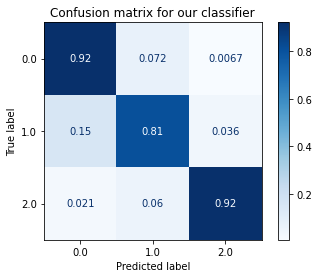

--------------------------------------- LightGBM ------------------------------
(2479, 199)
2479
Training Accuracy: 99.84101748807632 %
Test Accuracy: 88.58842617631151 %


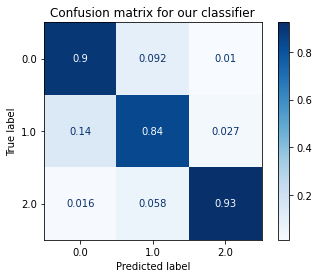

In [3]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import re
import nltk
from nltk.stem import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import _imaging
from sklearn.svm import SVC
from numpy import genfromtxt

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix

import csv
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
import pandas as pd

import numpy as np


def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:, np.argsort(
        np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


data = pd.read_csv('out.csv')
df = data
df = df.drop(columns=['Label'])
X = df
print(np.shape(X))
y = data['Label']
print(np.shape(X))


num_feats = 850
feature_name = X.columns.tolist()
cor_support, cor_feature = cor_selector(X, y, num_feats)

our_feature = []

our_feature.append(["Pearson Correlation", cor_feature])


# Chi-Squared
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=num_feats)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:, chi_support].columns.tolist()


our_feature.append(["Chi-Squared", chi_feature])

# Recursive Feature Elimination
rfe_selector = RFE(estimator=LogisticRegression(),
                   n_features_to_select=num_feats, step=30, verbose=5)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:, rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')


our_feature.append(["Recursive Feature Elimination", rfe_feature])


# Random Forest

embeded_rf_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100), max_features=num_feats)
embeded_rf_selector.fit(X, y)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:, embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

our_feature.append(["Random Forest", embeded_rf_feature])

# LightGBM


lgbc = LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                      reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
embeded_lgb_selector.fit(X, y)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X.loc[:, embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

our_feature.append(["LightGBM", embeded_lgb_feature])


for i in our_feature:
    my_data = pd.read_csv('/content/out.csv')
    print("---------------------------------------",
          i[0], "------------------------------")
    # print(my_data.head)
    # print(i[1])
    df = my_data[i[1]]
    # df = my_data
    X_ori = np.array(df)
    print(np.shape(X_ori))
    Y_ori = np.array(my_data['Label'])
    # print(type(my_data))

    data_length = np.shape(X_ori)[0]
    print(data_length)
    data_length = 900
    train_len = (int)(data_length*(0.7))
    test_len = (data_length-train_len)
    y_train = Y_ori[1:train_len]
    y_test = Y_ori[train_len:]
    X_train = X_ori[1:train_len, :-1]
    X_test = X_ori[train_len:, :-1]

    # print(X_ori)

    eeg_svc = SVC(C=1.0, kernel="linear")
    # print(type(eeg_svc))

    eeg_svc.fit(X_train, y_train.ravel())
    print("Training Accuracy:", (eeg_svc.score(X_train, y_train.ravel()))*100, "%")

    eeg_svc.predict(X_test)
    print("Test Accuracy:", (eeg_svc.score(X_test, y_test.ravel()))*100, "%")
    matrix = plot_confusion_matrix(eeg_svc,
                               X_test,
                               y_test,
                               cmap=plt.cm.Blues,
                               normalize='true')
    plt.title('Confusion matrix for our classifier')

    plt.show()
    

